##### Notes on a framework for Simulation Engine


 - Conceptual hierarchies involved in the Simulation engine

| spatial  | Temporal |
-----------|--------------
|Studies entities based with respect to geometric / topological / etc..(see work by Klaus) |Dynamics and evolution with respect to time|
|Spatial Statistics/ Cellular Automata/ Multi Agent Systems|Discrete / Continuous / Hybrid / State space models|


 - Initially, I consider primarily Temporal Dynamic systems considering interactions between variables as described by a causal graph
 
 - Kind of problems I am looking at
 
 
 
 
 - The relationships between variables shall be encoded by a directed graph (or possibly be a tree) with following node and edge attributes (note that edge attributes and edge flows are interchangeable in the context of this work)
     
     - Node attributes are the function describing how to transform the values transported by all incoming edge attributes
     
     - Edge attributes are the transformations of parent node values 
     
     
 - The origin node (aka "root") denotes the exogeneous node
 
 - At each time step, propagate computations down from exogeneous nodes

##### Data structure for simulation engine. 

Model the relationship between variables as an attributed graph, with the following attributes
 - Node attribute with dictionary keys 
     - function, which describes a transformation to be applied on to incoming flow varaibles
     - value, which describes the value of computation
     
 - Edge attribute with dictionary keys
     - function, which describes a transformation on edge flow variables


In [7]:
class CellDynamics:
    
    def __init__(self,flow_graph = None):
        '''
        what sort of graphs do we want to allow. Ideally Digraphs with node and edge with
        2 classes of attributes, funtion and value
        '''
        self.sim_graph = flow_graph
        self.clock = 0
        self.node_values ={}
        for _node in self.sim_graph.nodes:
            self.node_values[_node] = []
            
    def sort_graph(self):
        # Topologically sort the graph
        try:
            self.sorted_nodes = list(nx.algorithms.dag.topological_sort(self.sim_graph))
        except:
            # in case of cycles, use pagerank to order nodes
            pr = nx.pagerank(self.sim_graph)
            sorted_vals = sorted(pr.items(),key=lambda x:x[1],reverse=True)
            self.sorted_nodes = [_r[0] for _r in sorted_vals]
        
        
    
    def fit_params(self,node_values = {},fit_type='baseline'): 
        '''
        For the cases, where the edge attributes indicate dynamical relationships, solve the 
        dynamical system. Else, use fit()
        '''
        self.sort_graph()
            
        for _node in list(node_values.keys()):
            self.sim_graph.nodes[_node][fit_type] =node_values[_node]
        self.propagate_influences(attr_name=fit_type)
    
    def reset_flows(self):
        '''
        reset all edge flows / attributes to be None
        '''
        pass
    
    def clock_tick(self,**kwargs): 
        '''
        Do the bookkeeping ops with the clock tick.
        '''
        self.reset_flows()
        self.clock += 1
        #print('Tick tock %d'%(self.clock))
        self.propagate_influences()
        
    
    
    def propagate_influences(self,attr_name='val'):
        '''
        - At the next tick, apply the functional relationship of the node on the incoming edge values
        - set the edge values of all outgoing edges to be the node computation
        '''
        #print('Propagating vals')
        
        
        for _node in self.sorted_nodes:       
            # Nothing to be done for root nodes
            if len(list(self.sim_graph.in_edges(_node))) == 0:
                #print('Root node %s' %(_node))
                pass
            #  compute node attribute transformation of incoming edge flows / attributes
            else:
                edge_vals = []
                for _edge in list(self.sim_graph.in_edges(_node)):
                    try:
                        _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                        _parent_node_val =nx.get_node_attributes(self.sim_graph,attr_name)[_edge[0]]
                        edge_vals.append(_edge_fn(_parent_node_val))
                    except KeyError as e:
                        # COuld happen if graph has cycles
                        #edge_vals.append(0)
                        pass
                #print(edge_vals)
                # Compute the new node values after collecting edge values
                node_value = nx.get_node_attributes(self.sim_graph,'fn')[_node](*edge_vals)
                self.sim_graph.nodes[_node][attr_name] = node_value
                self.node_values[_node].append(node_value)
                
        
            
        
                
    def discrete_simulator(self,t_end,exogenous_node_vals = {}):
        #nx.set_node_attributes(self.sim_graph,exogenous_node_vals)
        

        for t_step in range(t_end):
            #print(t_step)
            for _node in list(exogenous_node_vals.keys()):
                #print(_node)
                self.sim_graph.nodes[_node]['val'] = exogenous_node_vals[_node][t_step]
            self.clock_tick()
            #self.sim_graph[]
            
        
        
            
                
        
    
        
    
    
    
    
        

Construct a simple graph, 2 exogeneous nodes and 3 endogeneous nodes. Just a thought model, One exogeneous node denotes the #infections and another some sort of cyclical signal (say recurrent lockdown). The endogneous nodes denote the system responses.

In [3]:
# Define a simple Simulation graph. Propagate values for 100 time steps or so. 

import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline


class SignalSmoother:
    def __init__(self,alpha,init_val):
        self.alpha = alpha
        self.val = init_val
            
    def next_ts(self,x):
        self.val = self.alpha*self.val + (1-self.alpha)*x
        return self.val
    


def run_graph(exp_coeff=-0.001,product_fn_coeff=2*np.pi,alpha_iidx=0.1,alpha_rto=0.1):
    sim_graph = nx.DiGraph([(1,2),(1,3),(2,4),(3,4)])
    nx.set_edge_attributes(sim_graph,{(1,2):{'fn':lambda x: 2*x},
                                      (1,3):{'fn':lambda x: np.sqrt(abs(x))},
                                      (2,4):{'fn':lambda x: x},
                                      (3,4):{'fn':lambda x: x},
                                      })

    
    def product_fn(x,y):
        return np.exp(-abs(x-y)**0.5)*y/(product_fn_coeff)
    
    def identity(x):
        return x
    
    def noisy_identity(x):
        return x + x*np.random.random()
    
    
    
    
    time_vals = np.array(range(100))
    str_vals = np.random.random(100)
    #alpha_iidx = 0.1
    #alpha_rto = 0.1
    
    filter_iidx = SignalSmoother(alpha=alpha_iidx,init_val=0)
    filter_rto = SignalSmoother(alpha=alpha_rto,init_val=0)


    nx.set_node_attributes(sim_graph,{1:{'fn':identity,'val':None},
                                      2:{'fn': filter_iidx.next_ts,'val':None},
                                      3:{'fn':filter_rto.next_ts,'val':None},
                                      4:{'fn': product_fn},
                                     })

    pos = nx.layout.spring_layout(sim_graph) 
    nx.draw_networkx(sim_graph,pos,labels={1:'stringency',2:'Industrial',3:'retail',4:'composite'},with_labels=True)
    plt.axis('off')
    plt.show()
    #nx.draw_networkx_labels(sim_graph,pos)

    simulator = CellDynamics(sim_graph)
    simulator.discrete_simulator(t_end=100,exogenous_node_vals={1:str_vals})
    out_vals = np.array(simulator.node_values[2])
    return out_vals, simulator

Run the graph and plot the results

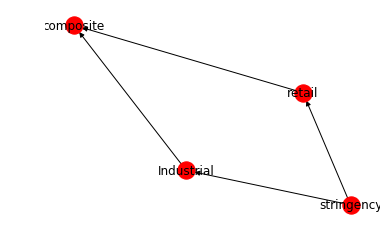

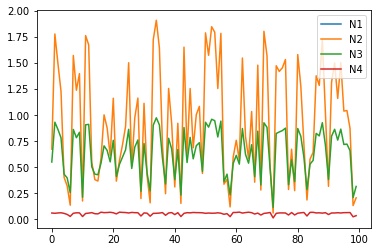

In [4]:
out_vals, simulator = run_graph()
plt.plot(simulator.node_values[1])
plt.plot(simulator.node_values[2])
plt.plot(simulator.node_values[3])
#simulator.node_values
plt.plot(simulator.node_values[4])
#plt.plot(simulator.node_values[5])
#plt.plot(np.array(list(range(100)))/100)
plt.legend(['N1','N2','N3','N4','N5'])

We will now ingest the IOTS dataset and build up the network.

In [13]:
import pandas as pd
df_iots = pd.read_csv('/project_data/data_asset/sun/economy/IOTSI4_2018_Domestic.csv')

def build_economic_flow_cell(_df):
    '''
    Function to model economic activity flow within a cell as an attributed graph
    '''
    G = nx.DiGraph()
    activity = list(set(list(_df['From: (sector in row)'].values) + list(_df['To: (sector in column)'].values)))
    #print(activity)
    G.add_nodes_from(activity)
    
    nx.set_node_attributes(G,lambda *x: sum(x)/len(x),name='fn')
    #nx.set_node_attributes(G,None,name=1)
    for index,row in _df.iterrows():
        G.add_edge(row['From: (sector in row)'],row['To: (sector in column)'])
        #if row['Unit'] == 'Percentage':
        nx.set_edge_attributes(G,{(row['From: (sector in row)'],row['To: (sector in column)']):
                                     {'fn':lambda x: x*row['Value']/100}})
        
        
    
    
    return G

# Consider that for Australia

_df = df_iots[(df_iots['Country']=='Australia') & (df_iots['Time']==2015)]

econ_flow_aus = build_economic_flow_cell(_df)
simulator = CellDynamics(econ_flow_aus)
#simulator.discrete_simulator(t_end=100,exogenous_node_vals={1:str_vals})





In [15]:
# Identify exogenoeus nodes
exog_nodes_dict_base = {}

for _node, _in_deg in econ_flow_aus.in_degree():
    if (_in_deg == 0):
        exog_nodes_dict_base[_node] = 1
    
    
simulator.fit_params(exog_nodes_dict_base)

exog_nodes_dict = {}

for _node,_in_deg in econ_flow_aus.in_degree():
    if (_in_deg == 0):
        exog_nodes_dict[_node] = 1+np.random.random(100)

    
#print(exog_nodes_dict)

#str_vals = np.random.random(100)
simulator.discrete_simulator(t_end=100,exogenous_node_vals=exog_nodes_dict)

In [16]:
simulator.node_values

{'Output at basic prices': [],
 'Manufacture of basic metals': [],
 'Other business sector services': [],
 'Financial and insurance activities': [],
 'Machinery and equipment, nec ': [2.5523413448944687,
  3.038573713087829,
  3.9540869757737305,
  4.6592661615375155,
  4.779972051620202,
  5.015061107102064,
  5.243611930665238,
  4.946207550652584,
  5.015683738174381,
  5.037920601221214,
  5.250084543093879,
  5.037461723511838,
  5.15127371021482,
  5.163954042599735,
  5.270720765929779,
  5.266909823568531,
  5.165938744339313,
  5.244040831592708,
  5.155446636231453,
  5.1072822289819895,
  5.2219923515686615,
  5.234560731681276,
  5.222133564501136,
  5.134219839568582,
  5.251921579127499,
  5.342075247342512,
  5.133312928157912,
  5.070624898112322,
  5.107838977922627,
  5.1751339959742095,
  5.305528123924943,
  5.087265392556146,
  5.226083028145035,
  4.939522462443921,
  5.031464803349219,
  5.037359246253613,
  5.163913527340452,
  5.166527614518328,
  5.06318208643

A simple integration tril with EMA workbench

In [ ]:
try:
    from ema_workbench import RealParameter, ScalarOutcome, Constant,Model, ArrayOutcome
    from ema_workbench import MultiprocessingEvaluator, ema_logging,perform_experiments
    ema_logging.log_to_stderr(ema_logging.INFO)

except ModuleNotFoundError:
    !pip install ema_workbench
    from ema_workbench import RealParameter, ScalarOutcome, Constant,Model, ArrayOutcome
    from ema_workbench import MultiprocessingEvaluator, ema_logging,perform_experiments
    ema_logging.log_to_stderr(ema_logging.INFO)
    


In [ ]:
model = Model('simengine', function=run_graph)
model.uncertainties = [RealParameter('alpha_iidx', 0, 1)
                       ]

model.levers = [RealParameter('alpha_rto', 0, 1)
                       ]

model.outcomes = [ArrayOutcome('out_4')]


with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=50, policies=4)

In [ ]:
expers, outcomes = results

In [ ]:
import pandas as pd
plt.hist(outcomes['out_4'].mean(axis=1))

plt.title('Distribution of Node 2 for scenario models')

In [ ]:
outcomes